# PyTorch를 사용한 훈련
아래 동영상을 따라가거나 youtube 링크에서 확인하세요.

.. raw:: html

   <div style="margin-top:10px; margin-bottom:10px;">
     <iframe width="560" height="315" src="https://www.youtube.com/embed/jF43_wj_DCQ" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
   </div>

## 소개
과거 동영상에서는 다음과 같은 내용을 논의하고 시연했습니다:

torch.nn 모듈의 신경망 레이어 및 기능을 사용하여 모델 구축
기울기 기반 모델 훈련에 중요한 자동 기울기 계산 메커니즘
TensorBoard를 사용하여 훈련 진행 및 기타 활동 시각화
이번 동영상에서는 인벤토리에 새로운 도구를 추가할 것입니다:

데이터셋 및 데이터로더 추상화에 대해 이해하고, 훈련 루프 중에 모델에 데이터를 공급하는 과정을 살펴봅니다.
특정 손실 함수 및 사용 시기에 대해 논의합니다.
PyTorch 옵티마이저를 살펴보며, 이는 손실 함수의 결과를 기반으로 모델 가중치를 조절하는 알고리즘을 구현합니다.
마지막으로, 이러한 모든 요소를 통합하여 PyTorch 훈련 루프를 실제로 보게 될 것입니다.

## 데이터셋 및 데이터로더
Dataset 및 DataLoader 클래스는 데이터를 저장소에서 가져와 훈련 루프에 일괄로 노출하는 프로세스를 캡슐화합니다.

Dataset은 데이터의 단일 인스턴스에 액세스하고 처리하는 데 책임이 있습니다.

DataLoader는 Dataset에서 데이터 인스턴스를 가져와 (자동으로 또는 사용자가 정의한 샘플러와 함께), 이를 일괄로 수집하여 훈련 루프에서 사용할 수 있도록 반환합니다. DataLoader는 데이터의 유형과 상관없이 모든 종류의 데이터셋과 함께 작동합니다.

이 자습서에서는 TorchVision에서 제공하는 Fashion-MNIST 데이터셋을 사용합니다. 우리는 torchvision.transforms.Normalize()를 사용하여 이미지 타일 내용의 분포를 제로 중심으로 정규화하고, 훈련 및 검증 데이터 분할을 모두 다운로드합니다.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


평소와 같이 데이터를 시각화하여 정상 여부를 확인해보겠습니다

Shirt  T-shirt/top  Pullover  Ankle Boot


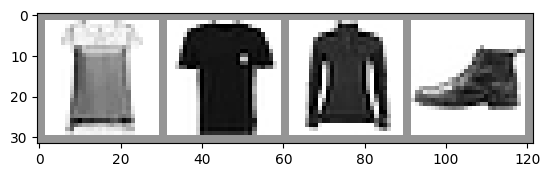

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [2]:
# jupyternotebook error
# import os
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


## 모델

이 예제에서 사용할 모델은 LeNet-5의 변형입니다. 이전 시리즈의 동영상을 시청한 적이 있다면 이 모델이 익숙할 것입니다.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()


## 손실 함수

이 예제에서는 교차 엔트로피 손실을 사용합니다. 데모를 위해 더미 출력과 레이블 값을 생성하고, 이들을 손실 함수를 통과시켜 결과를 확인할 것입니다.


In [6]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.2675, 0.7500, 0.7151, 0.1336, 0.8680, 0.6493, 0.8474, 0.8140, 0.4635,
         0.7035],
        [0.6280, 0.6337, 0.6495, 0.4431, 0.0508, 0.8207, 0.8367, 0.6804, 0.2518,
         0.9701],
        [0.1388, 0.9652, 0.4019, 0.0399, 0.1507, 0.2410, 0.4998, 0.6952, 0.3640,
         0.7359],
        [0.2837, 0.0153, 0.7842, 0.7790, 0.6908, 0.1116, 0.1455, 0.0465, 0.3354,
         0.0077]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.415609836578369


## 옵티마이저
이 예제에서는 모멘텀을 사용한 단순한 확률적 경사 하강법 (Stochastic Gradient Descent, SGD)_을 사용할 것입니다.

이 최적화 기법에 대한 몇 가지 변형을 시도하는 것은 유익할 수 있습니다:

학습률은 옵티마이저가 취하는 단계의 크기를 결정합니다. 서로 다른 학습률이 정확도와 수렴 시간에 어떤 영향을 미치는지 확인해 보세요.
모멘텀은 최적화기를 여러 단계 동안 가장 강력한 그래디언트 방향으로 밀어냅니다. 이 값을 변경하면 결과에 어떤 영향을 미치는지 살펴보세요.
평균 SGD, Adagrad, 또는 Adam과 같은 다양한 최적화 알고리즘을 시도해 보세요. 결과가 어떻게 다르게 나타나는지 확인해보세요.

In [7]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


## 훈련 루프
아래에는 하나의 훈련 에폭을 수행하는 함수가 있습니다. 이 함수는 DataLoader에서 데이터를 열거하며 각 루프의 통과마다 다음을 수행합니다:

- DataLoader에서 훈련 데이터의 배치를 가져옵니다.
- 옵티마이저의 그래디언트를 0으로 설정합니다.
- 추론을 수행합니다. 즉, 입력 배치에 대한 모델의 예측을 얻습니다.
- 해당 예측과 데이터셋의 레이블 간의 손실을 계산합니다.
- 학습 가중치에 대한 역방향 그래디언트를 계산합니다.
- 옵티마이저에게 학습 단계를 수행하도록 지시합니다. 즉, 선택한 최적화 알고리즘에 따라 이 배치에 대한 관측된 그래디언트를 기반으로 모델의 학습 가중치를 조정합니다.
- 매 1000 배치마다 손실을 보고합니다.
- 마지막 1000 배치에 대한 평균 배치당 손실을 보고합니다. 이 값은 검증 실행과 비교하기 위한 것입니다.

In [8]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

## 에폭 당 활동
에폭 당으로 수행할 몇 가지 작업이 있습니다:

훈련에 사용되지 않은 데이터 세트에서 상대적인 손실을 확인하여 검증을 수행하고 이를 보고합니다.
모델의 복사본을 저장합니다.
여기서 우리는 TensorBoard에서 보고를 수행할 것입니다. 이를 위해서는 명령 줄에서 TensorBoard를 시작하고 다른 브라우저 탭에서 열어야 합니다.

In [9]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 1.7203059770613909
  batch 2000 loss: 0.8727156349495053
  batch 3000 loss: 0.7308477423321456
  batch 4000 loss: 0.6411446691597812
  batch 5000 loss: 0.6036272091376595
  batch 6000 loss: 0.560890505601652
  batch 7000 loss: 0.5707613034034148
  batch 8000 loss: 0.510251914864406
  batch 9000 loss: 0.498426133526722
  batch 10000 loss: 0.4857211941695423
  batch 11000 loss: 0.4740640135895228
  batch 12000 loss: 0.4840794144971296
  batch 13000 loss: 0.418788526377175
  batch 14000 loss: 0.4320271786942612
  batch 15000 loss: 0.4457311078328639
LOSS train 0.4457311078328639 valid 0.4384363293647766
EPOCH 2:
  batch 1000 loss: 0.419783098748303
  batch 2000 loss: 0.39336217006485097
  batch 3000 loss: 0.400690537323826
  batch 4000 loss: 0.3941113630041946
  batch 5000 loss: 0.3710038700651494
  batch 6000 loss: 0.4130218063859793
  batch 7000 loss: 0.3797886263743276
  batch 8000 loss: 0.38840005502995334
  batch 9000 loss: 0.38306011995195877
  batch 1000

모델을 저장한 후 불러오려면 다음과 같이 할 수 있습니다:

python
Copy code
saved_model = GarmentClassifier()
saved_model.load_state_dict(torch.load(PATH))
모델을 로드한 후에는 추가적인 훈련, 추론 또는 분석에 사용할 수 있습니다.

단, 모델에 모델 구조에 영향을 주는 생성자 매개변수가 있다면 해당 매개변수를 제공하고 모델을 저장된 상태와 동일하게 구성해야 합니다.

## 기타 자료
- PyTorch 공식 문서에서 데이터 유틸리티에 관한 내용, 즉 Dataset 및 DataLoader에 대한 정보를 찾을 수 있습니다.
- GPU 훈련에 대한 고정 메모리 사용에 대한 노트
- TorchVision의 사용 가능한 데이터셋에 대한 문서
- TorchText 및 TorchAudio에 대한 데이터셋 문서
- PyTorch에서 사용 가능한 손실 함수 문서
- torch.optim 패키지 문서, 이는 최적화기 및 학습률 스케줄링과 같은 관련 도구를 포함합니다.
- 모델을 저장하고 불러오는 자세한 튜토리얼
- pytorch.org의 튜토리얼 섹션에는 다양한 훈련 작업에 대한 자습서가 포함되어 있습니다. 이는 다양한 도메인에서의 - 분류, 생성적 적대 신경망, 강화 학습 등을 다룹니다.